In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager,rc
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from termcolor import colored as cl # text customization
from mpl_toolkits.mplot3d import Axes3D # 3d plot

In [2]:
# 폰트 깨지지 않게 하는 것 

plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

# 1. 파일 리딩

In [3]:
raw_data = pd.read_excel('./Press_RawDataSet.xlsx')
raw_data.head()

,idx,Machine_Name,Item No,working time,Press time(ms),Pressure 1,Pressure 2,Pressure 5
0,1,Press-01,ED5260,2020-05-04 00:00:00,550.0,275.0,274.0,549.0
1,2,Press-01,ED5260,2020-05-04 00:00:00,550.0,275.0,274.0,549.0
2,3,Press-01,ED5260,2020-05-04 00:00:00,550.0,275.0,275.0,550.0
3,4,Press-01,ED5260,2020-05-04 00:00:00,550.0,275.0,275.0,550.0
4,5,Press-01,ED5260,2020-05-04 00:00:00,549.2,274.6,276.0,550.6


# 2. 전처리

In [4]:
# 시,분,초 제거 

time = []
for i in raw_data['working time']:
    j = str(i).replace(' 00:00:00','')
    time.append(j)
# time[0]

raw_data['working time'] = time

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64359 entries, 0 to 64358
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   idx             64359 non-null  int64  
 1   Machine_Name    64359 non-null  object 
 2   Item No         64359 non-null  object 
 3   working time    64359 non-null  object 
 4   Press time(ms)  64359 non-null  float64
 5   Pressure 1      64359 non-null  float64
 6   Pressure 2      64359 non-null  float64
 7   Pressure 5      64359 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.9+ MB


In [6]:
# 특정 날짜 추출 '2020-05-04', '2020-05-29' 사이
new_data = raw_data[(raw_data["working time"] >= '2020-05-04') & (raw_data["working time"] <= '2020-05-29')]
new_data['working time'].unique()

# cf sol2) 특정 기간의 데이터 추출하기 -> between 사용 
# new_data_1 = raw_data.loc[raw_data["working time"].between('2020-05-04', '2020-05-29')]
# new_data_1['working time'].unique()

array(['2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
       '2020-05-08', '2020-05-12', '2020-05-13', '2020-05-14',
       '2020-05-15', '2020-05-18', '2020-05-20', '2020-05-21',
       '2020-05-22', '2020-05-25', '2020-05-26', '2020-05-27',
       '2020-05-28', '2020-05-29'], dtype=object)

In [7]:
# 특정 열 추출 
new_data = new_data.drop(columns=['idx','Machine_Name','Item No','working time','Press time(ms)','Pressure 5'],axis=1) 
new_data = new_data.reset_index(drop=True)
new_data

,Pressure 1,Pressure 2
0,275.0,274.0
1,275.0,274.0
2,275.0,275.0
3,275.0,275.0
4,274.6,276.0
...,...,...
62720,275.0,267.0
62721,274.9,269.0
62722,274.9,269.0
62723,275.3,267.0


## < 변수 2개 사용 -> pressure 1, 2 사용 >

# 3. scaling

In [8]:
# 필요 패키지 불러오기 (KMeans, matplotlib, preprocessing)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [9]:
# 원본 데이터를 복사해서 전처리하기 (원본 데이터를 가지고 바로 전처리하지 않는다)
processed_data = new_data.copy()
processed_data

,Pressure 1,Pressure 2
0,275.0,274.0
1,275.0,274.0
2,275.0,275.0
3,275.0,275.0
4,274.6,276.0
...,...,...
62720,275.0,267.0
62721,274.9,269.0
62722,274.9,269.0
62723,275.3,267.0


* 스케일링의 종류 
- https://mkjjo.github.io/python/2019/01/10/scaler.html
- StandardScaler :	기본 스케일. 평균과 표준편차 사용 -> 분석시 사용
- MinMaxScaler :	최대/최소값이 각각 1, 0이 되도록 스케일링  
- MaxAbsScaler :	최대절대값과 0이 각각 1, 0이 되도록 스케일링
- RobustScaler :	중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화

In [10]:
# 데이터 전처리 - 정규화를 위한 작업-> standard scling 사용 
scaler = preprocessing.StandardScaler()
processed_data.iloc[:,[0,1]] = scaler.fit_transform(processed_data.iloc[:,[0,1]])
processed_data.values

array([[-0.0650941 ,  1.4034494 ],
       [-0.0650941 ,  1.4034494 ],
       [-0.0650941 ,  1.74076585],
       ...,
       [-0.1607243 , -0.28313286],
       [ 0.22179651, -0.95776577],
       [ 0.22179651, -0.95776577]])

In [11]:
# Minmax 사용 
# scaler = preprocessing.MinMaxScaler()
# processed_data.iloc[:,[0,1,2,3]] = scaler.fit_transform(processed_data.iloc[:,[0,1,2,3]])
# processed_data.values

# 4. k-means

- k-means parameter


- init- 중심의 초기화 방법
- n_clusters- 형성 할 클러스터의 수와 생성 할 중심의 수
- n_init -k- 평균 알고리즘이 다른 중심 시드로 실행되는 횟수


-

4-1. 실루엣 계수를 통해 가장 적합한 군집의 갯수 선택 -> k= 4 일때가 가장 적합한 것을 확인 
- https://velog.io/@sset2323/07-02.-%EA%B5%B0%EC%A7%91-%ED%8F%89%EA%B0%80Cluster-Evaluation

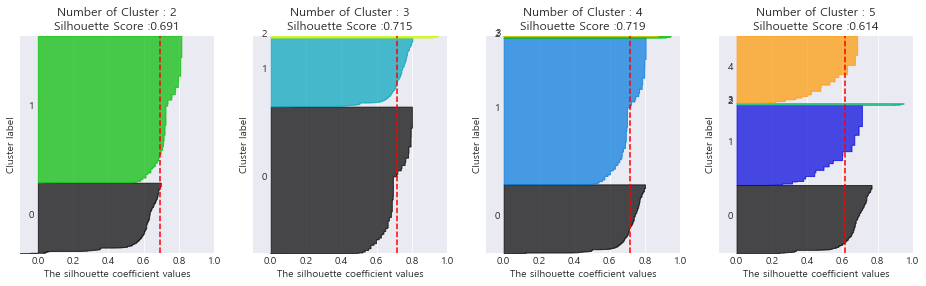

In [12]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5],processed_data.iloc[:,[0,1]])

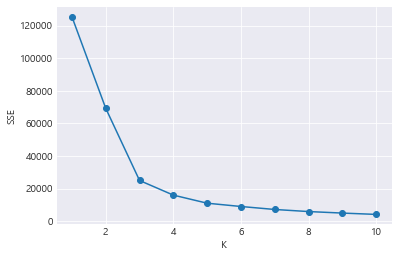

In [13]:
# 엘보우 차트 기준으로도 k= 4 가 적합 

def elbow(X):
    sse = []

    for i in range(1,11):
        clusterer = KMeans(n_clusters = i, max_iter=500, random_state=0)
        clusterer.fit(X)
        sse.append(clusterer.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()

elbow(processed_data.values)

4-2. k = 4의 k-means 클러스터 분석 결과

In [14]:
# k-means MODELING

# cluster 갯수 설정
n_cluster = 4
clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
cluster_labels = clusterer.fit_predict(processed_data.iloc[:,[0,1]].values)

# 레이블 df에 추가 
processed_data['cluster_num'] = cluster_labels
processed_data

,Pressure 1,Pressure 2,cluster_num
0,-0.065094,1.403449,0
1,-0.065094,1.403449,0
2,-0.065094,1.740766,0
3,-0.065094,1.740766,0
4,-0.447615,2.078082,0
...,...,...,...
62720,-0.065094,-0.957766,1
62721,-0.160724,-0.283133,1
62722,-0.160724,-0.283133,1
62723,0.221797,-0.957766,1


In [15]:
# k-means clustering으로 계산된 값 
clusterer.inertia_ 

16016.321766153742

4-3. k-means 결과 시각화

(1) 분포별 시각화

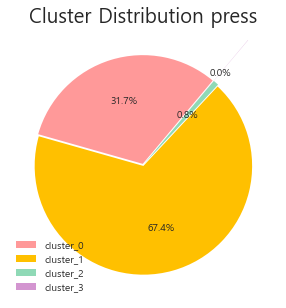

In [16]:
# label별 분포 -> 시각화 (파이차트)

import collections
import matplotlib.pyplot as plt

label_name = []
sizes = []
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
explode = [0.01, 0.01, 0.01, 0.5]
for i in range(clusterer.n_clusters):
  label_name.append("cluster_"+str(i))
  sizes.append(collections.Counter(processed_data['cluster_num'])[i])
plt.figure(figsize=(10,5))
plt.pie(sizes,shadow=False,startangle=50,autopct='%1.1f%%',colors=colors,explode=explode)
plt.title("Cluster Distribution press",position=(0.5,1.2),fontsize=20)
plt.legend(label_name)
plt.show()

In [17]:
# 레이블 별 분포 결과
processed_data['cluster_num'].value_counts()

1    42301
0    19893
2      511
3       20
Name: cluster_num, dtype: int64

In [18]:
# 데이터 세트에 있는 각 속성의 평균 
data_mean = processed_data.groupby('cluster_num').mean()
data_mean

,Pressure 1,Pressure 2
cluster_num,,
0,-0.065089,1.353675
1,-0.072489,-0.651943
2,9.366552,1.272219
3,-21.256747,-0.047011


<AxesSubplot:xlabel='cluster_num'>

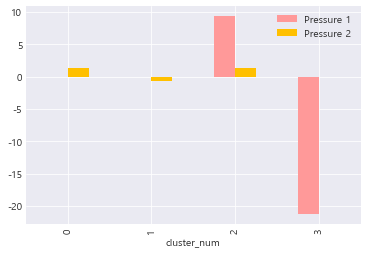

In [19]:
# 데이터 세트에 있는 각 속성의 평균 
data_mean = processed_data.groupby('cluster_num').mean().plot.bar(color = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'])
data_mean

In [20]:
# data_mean[['Pressure 1','Pressure 2']].plot(kind='box')

(2) pca 2차원 축소후 시각화 결과

In [21]:
# pca 2차원으로 축소 

from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(processed_data.iloc[:,[0,1]].values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# index 재정렬 필요 
processed_data = processed_data.reset_index(drop=True)
processed_data

# 기존에 있던 label과 합치기
finalDataFrame = pd.concat([principalDf, processed_data[['cluster_num']]], axis=1)
finalDataFrame

,principal component 1,principal component 2,cluster_num
0,-0.946360,1.038417,0
1,-0.946360,1.038417,0
2,-1.184879,1.276936,0
3,-1.184879,1.276936,0
4,-1.152915,1.785938,0
...,...,...,...
62720,0.723271,-0.631214,1
62721,0.313854,-0.086556,1
62722,0.313854,-0.086556,1
62723,0.520409,-0.834076,1


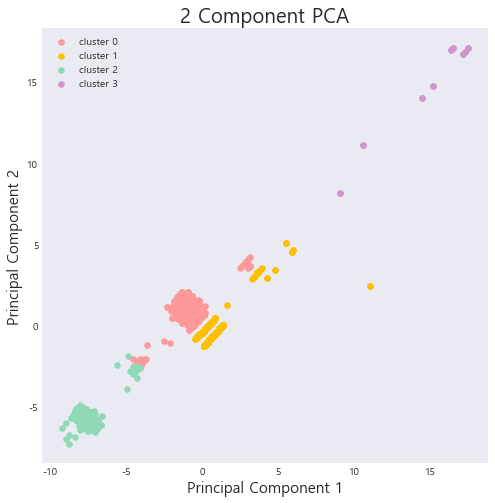

In [22]:
# pca 시각화 결과 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

label_name = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
for label, color in zip(list(set(cluster_labels)), colors):
    indicesToKeep = finalDataFrame['cluster_num'] == label
    ax.scatter(finalDataFrame.loc[indicesToKeep, 'principal component 1']
               , finalDataFrame.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 30)

ax.legend(label_name)
ax.grid()

In [23]:
# pca 2차원으로 축소시에 100퍼센트 이상 설명 가능 -> pca 2차원이 가장 적합 
sum(pca.explained_variance_ratio_)

1.0

(4) 2차원 t-sne로 시작화 
- https://mkjjo.github.io/finance/2019/01/09/kmeans_corp.html

In [24]:
import numpy as np
from sklearn.manifold import TSNE

# 2개의 차원으로 축소
transformed = TSNE(n_components=2).fit_transform(processed_data.iloc[:,[0,1]])
transformed.shape

# x,y축
xs = transformed[:,0]
ys = transformed[:,1]


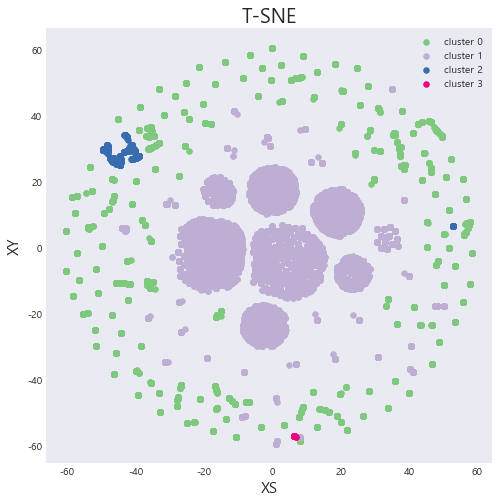

In [25]:
# t-sne 시각화 과정 

# DataFrame 변환
transformed_DF=pd.DataFrame(transformed)
transformed_DF

# 레이블 CONCAT
TSNE = pd.concat([transformed_DF, processed_data[['cluster_num']]], axis=1)
TSNE

# T-SNE 시각화
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('XS', fontsize = 15)
ax.set_ylabel('XY', fontsize = 15)
ax.set_title('T-SNE', fontsize = 20)

label_name = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
colors = ["#7fc97f","#beaed4","#386cb0","#f0027f"]
for label, color in zip(list(set(cluster_labels)), colors):
  indicesToKeep = finalDataFrame['cluster_num'] == label
  ax.scatter(TSNE.loc[indicesToKeep, 0]
               , TSNE.loc[indicesToKeep, 1]
               , c = color
               , s = 30)

ax.legend(label_name)
ax.grid()

4-4. gmm 알고리즘

- 결론 : gmm도 찍어봤어 but, 불량률을 판정하기 어려웠음 
- appendix로 빼면 될듯 (다른 버리는 알고리즘이랑 한번 언급 정도 해주면 될듯)
- 실루엣 계수 결과 cluster는 4일 때가 가장 적합함 but, 하나의 그룹이 400개가 존재하기 때문에 적합하지 않음

In [26]:
# 데이터 설정
gmm = new_data.copy()

# 정규화
scaler = StandardScaler()
input_data = scaler.fit_transform(gmm.iloc[:,[0,1]]) # iloc에서 열 기준으로는 처음이 1로 시작 

In [27]:
input_data = pd.DataFrame(input_data)
input_data

,0,1
0,-0.065094,1.403449
1,-0.065094,1.403449
2,-0.065094,1.740766
3,-0.065094,1.740766
4,-0.447615,2.078082
...,...,...
62720,-0.065094,-0.957766
62721,-0.160724,-0.283133
62722,-0.160724,-0.283133
62723,0.221797,-0.957766


(1) 2개의 clustering 

In [28]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(input_data)
gmm_labels = gmm.predict(input_data)

new_data['gmm_cluster'] = gmm_labels
new_data['gmm_cluster'].value_counts()

1    42378
0    20347
Name: gmm_cluster, dtype: int64

(2) 3개의 clustering 

In [29]:
gmm = GaussianMixture(n_components = 3)
gmm.fit(input_data)
gmm_labels = gmm.predict(input_data)

new_data['gmm_cluster'] = gmm_labels
new_data['gmm_cluster'].value_counts()

0    42286
1    19818
2      621
Name: gmm_cluster, dtype: int64

(3) 4개의 clustering

In [30]:
gmm = GaussianMixture(n_components = 4)
gmm.fit(input_data)
gmm_labels = gmm.predict(input_data)

new_data['gmm_cluster'] = gmm_labels
new_data['gmm_cluster'].value_counts()

0    23098
1    19847
3    19159
2      621
Name: gmm_cluster, dtype: int64

(3) 5개의 clustering

In [31]:
gmm = GaussianMixture(n_components = 5)
gmm.fit(input_data)
gmm_labels = gmm.predict(input_data)

new_data['gmm_cluster'] = gmm_labels
new_data['gmm_cluster'].value_counts()

0    23098
1    19850
3    19159
2      487
4      131
Name: gmm_cluster, dtype: int64

In [32]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(input_data)
gmm_labels = gmm.predict(input_data)

new_data['gmm_cluster'] = gmm_labels
new_data['gmm_cluster'].value_counts()

4    23098
0    19159
1    14838
5     4998
2      487
3      145
Name: gmm_cluster, dtype: int64

In [33]:
gmm = GaussianMixture(n_components = 7)
gmm.fit(input_data)
gmm_labels = gmm.predict(input_data)

new_data['gmm_cluster'] = gmm_labels
new_data['gmm_cluster'].value_counts()

5    23098
0    19159
2    14689
1     4998
3      487
6      161
4      133
Name: gmm_cluster, dtype: int64

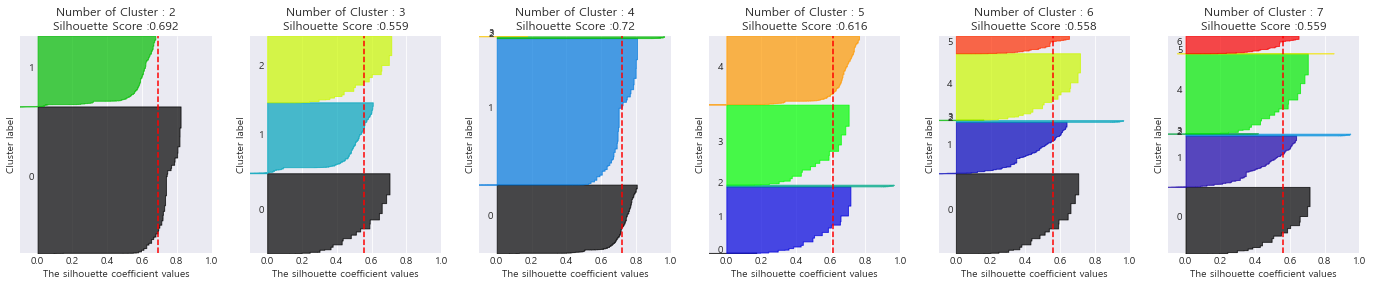

In [34]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        
        clusterer = GaussianMixture(n_components = n_cluster)
        clusterer.fit(X_features)
        cluster_labels = clusterer.predict(X_features)
        
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2,3,4,5,6,7],input_data.iloc[:,[0,1]])

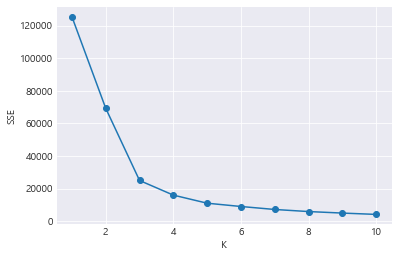

In [35]:
def elbow(X):
    sse = []

    for i in range(1,11):
        clusterer = KMeans(n_clusters = i, max_iter=500, random_state=0)
        clusterer.fit(X)
        sse.append(clusterer.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()

elbow(input_data.values)